## Структура файла
#### Поиск оптимального портфеля
- Скачивание данных по ряду активов: голубые фишки, безрисковые инвестиции в гос. облигации
- Генерация случайных портфелей, их оценка. Построение Допустимого множества инвестиционных альтернатив
- Поиск эффективной границы множества
- Выбор оптимального портфеля, исходя из предпосылок об отношении к риску индивидов

#### Генерация траекторий цен активов на 20 лет
- Geometric Brownian Motion 
- Monte Carlo simulations с сохранением параметров активов

#### Вычисление распределения доходности нашего портфеля
- Написание инвестиционной стратегии в виде скрипта: 
- - Покупка новых активов при поступлении денег
- - Ребалансировка портфеля в соответствии с найденным оптимумом
- Вычисление доходности портфеля на основе сгенерированных рядов цен

# Поиск оптимального портфеля

In [29]:
import numpy as np
import pandas as pd
from pandas_datareader import data

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from copy import deepcopy

import yfinance as yf
import pandas_datareader as pdr

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

In [24]:
def make_stock_table(start_date, end_date, stocks=blue_chips_names, market_proxy='IMOEX'):
    df = pd.DataFrame()
    for stock in stocks:
        cur_series = pdr.get_data_moex(stock, start=start_date, end=end_date)['CLOSE']
        df[stock] = cur_series
    cur_series = pdr.get_data_moex(market_proxy, start=start_date, end=end_date)['CLOSE']
    df_market_proxy = cur_series.to_frame()
    del cur_series

    return df, df_market_proxy


def plot_stock_performance(df1, df2=None, df2_col='IMOEX'):
    plt.figure(figsize=(12, 5))
    for col in df1.columns.values:
        sns.lineplot(data=df1[col], label=col)
    sns.lineplot(data=df2[df2_col], label=df2_col, linestyle='--')
    plt.title('Price of the Stocks')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Price in RUR', fontsize=18)
    plt.legend(
        np.append(df1.columns.values, df2_col), loc='upper left'
    )
    plt.show();
    
    
def calc_betas(df1, df2=None, df2_col='IMOEX'):
    dict_assets_covariance_imoex = {}
    for col in df1.columns.values:
        dict_assets_covariance_imoex[col] = df1[col].cov(df2[df2_col])
    
    mkt_disp = df2[df2_col].std(ddof=0) ** 2
    dict_asset_betas = {
        ticker: cov / mkt_disp for ticker, cov in dict_assets_covariance_imoex.items()
    }
    return dict_asset_betas

asset_daily_betas = calc_betas(
    df1=df_assets_performance, df2=df_benchmark_performance
)

def check_beta_sustainability(df1, df2):
    df_11 = df1.copy(); df_21 = df2.copy()
    daily_betas = calc_betas(df_11, df_21)

    df_sust = pd.DataFrame.from_dict(
        daily_betas, orient='index', columns=['daily_beta']
    )

    monthly_1_betas = calc_betas(
        df_11.loc[df_11.index.is_month_start], df_21.loc[df_21.index.is_month_start]
    )
    series_tmp = pd.Series(monthly_1_betas)
    df_sust['monthly_1_beta'] = series_tmp
    del series_tmp

    monthly_last_betas = calc_betas(
        df_11.loc[df_11.index.is_month_end], df_21.loc[df_21.index.is_month_end]
    )
    series_tmp = pd.Series(monthly_last_betas)
    df_sust['monthly_last_beta'] = series_tmp
    del series_tmp

    monthly_avg_betas = calc_betas(
        df_11.resample('M').mean(), df_21.resample('M').mean()
    )
    series_tmp = pd.Series(monthly_avg_betas)
    df_sust['monthly_avg_beta'] = series_tmp
    del series_tmp

    monthly_cumulative_betas = calc_betas(
        df_11.resample('M').sum(), df_21.resample('M').sum()
    )
    series_tmp = pd.Series(monthly_cumulative_betas)
    df_sust['monthly_cumulative_beta'] = series_tmp
    del series_tmp

    return df_sust


def make_corr_mat(df):
    corr_mat = df.corr()
    plt.figure(figsize=(12, 5))
    sns.heatmap(corr_mat, annot = True)
    plt.title('Correlation Matrix')
    plt.xlabel('Assets', fontsize=18)
    plt.ylabel('Assets', fontsize=18)
    plt.show();


def make_pie_graph_weights(dict_weights):
    dict_weights_non_zero = {
        key: dict_weights[key] for key in dict_weights if dict_weights[key] != 0
    }

    colors = sns.color_palette('pastel')
    plt.pie(
    #    dict_weights_non_zero.values(), labels=dict_weights_non_zero.keys(), colors=colors, autopct='%.1f%%'
        dict_weights_non_zero.values(), labels=dict_weights_non_zero.keys(), colors=colors, autopct=''
    )
    plt.show();
    
    
def plot_efficient_frontier(ef):
    fig, ax = plt.subplots()
    ef_max_sharpe = ef.deepcopy()
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True, show_tickers=True)

    # Find the tangency portfolio
    ef_max_sharpe.max_sharpe()
    ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

    # Generate random portfolios
    n_samples = 10000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

    # Output
    ax.set_title("Efficient Frontier with random portfolios")
    ax.legend()
    plt.tight_layout()
    # plt.savefig("ef_scatter.png", dpi=200)
    plt.show();

In [14]:
blue_chips_names = np.array(
    ['GAZP', 'GEMC', 'YNDX', 'VKCO', 'POSI', 'FLOT', 'UNAC', 'NMTP', 'FESH', 'PIKK', 'AFLT',
     'DSKY', 'MVID', 'MGNT', 'OZON', 'POLY', 'ALRS', 'NLMK', 'PHOR', 'MTSS', 'SBER', 'TCSG', 
     'IRAO', 'NVTK', 'ROSN']
)
blue_chips_names.astype(str)



# берем данные за 5 лет
df_assets, df_benchmark = make_stock_table('31-10-2018', '31-10-2023')

small_df = deepcopy(df_assets)

df_assets = small_df.drop(['GEMC', 'VKCO', 'POSI', 'FLOT', 'TCSG', 'OZON'], axis=1)

df_benchmark.rename(columns={'CLOSE': "IMOEX"}, inplace=True)



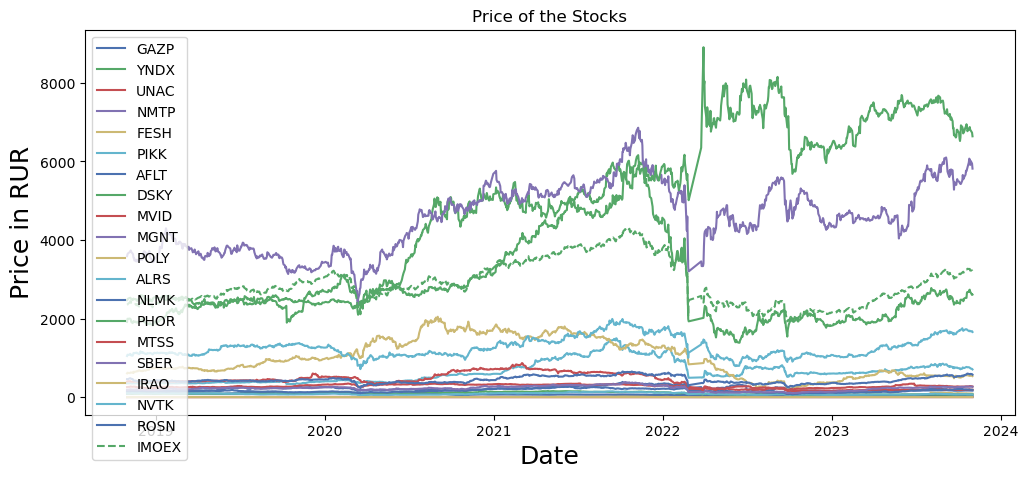

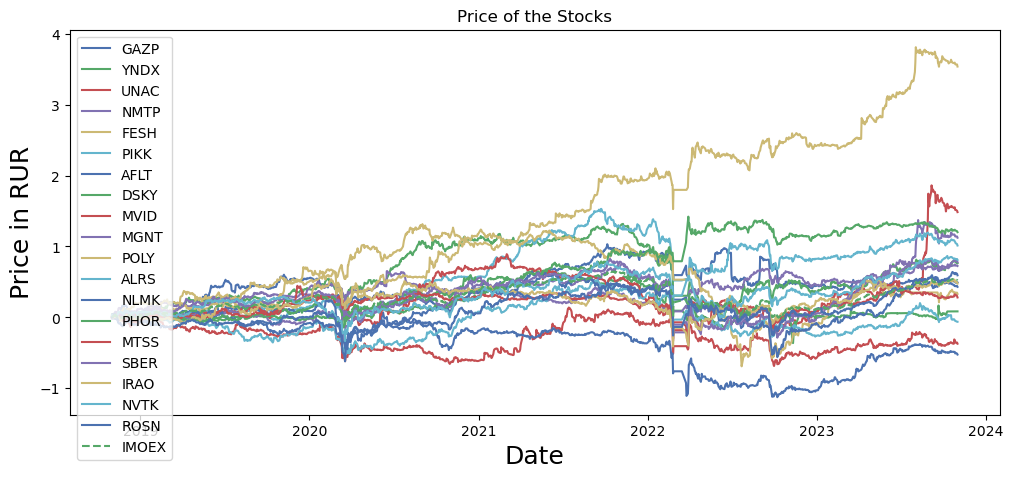

In [15]:
plot_stock_performance(df1=df_assets, df2=df_benchmark)
plot_stock_performance(
    df1=df_assets.pct_change()[1:].cumsum(), 
    df2=df_benchmark.pct_change()[1:].cumsum()
)

In [16]:
# подбор оптимальных весов
df_assets_performance = df_assets.pct_change()[1:]
df_benchmark_performance = df_benchmark.pct_change()[1:]

# считаем cov(r_i, r_m) -- ковариацию доходности каждой акции и индекса
# считаем sigma^2_m -- дисперсию рыночной доходности
# считаем beta для каждой акции


all_betas = check_beta_sustainability(
    df_assets_performance, df_benchmark_performance
).round(decimals=4)


rfr = 11.92 / 100
erp = 0.10
exp_returns = rfr + all_betas.monthly_avg_beta * erp


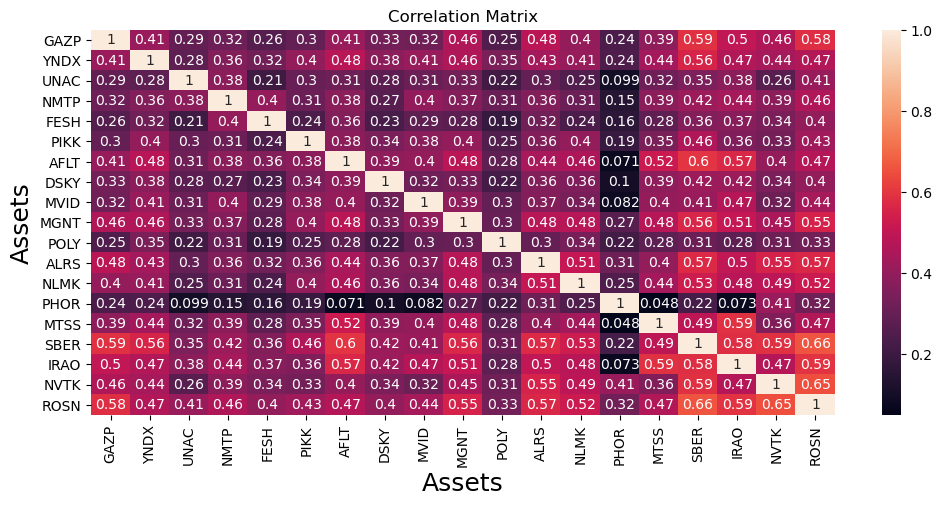

In [17]:
make_corr_mat(df_assets_performance)

In [18]:
assets_cov = df_assets_performance.cov() * 252
ef = EfficientFrontier(exp_returns, assets_cov, weight_bounds=(0,1))
opt_weights = ef.max_sharpe()
cleaned_opt_weights = ef.clean_weights() 

df_assets111 = df_assets.copy(); df_benchmark111 = df_benchmark.copy()
ret = expected_returns.capm_return(
    df_assets111, market_prices = df_benchmark111, compounding=False,
    returns_data=False, risk_free_rate=rfr, frequency=252
)

df_assets112 = df_assets.copy(); df_benchmark112 = df_benchmark.copy()
ret1 = expected_returns.capm_return(
    df_assets112, market_prices = df_benchmark112, compounding=False,
    returns_data=False, risk_free_rate=rfr, frequency=252
)


    

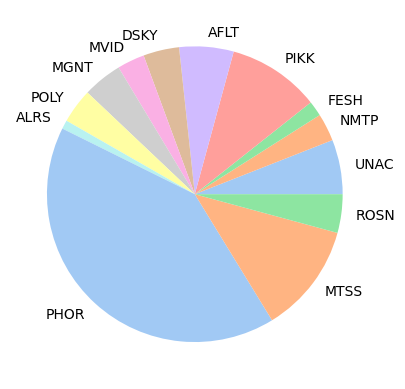

In [25]:
make_pie_graph_weights(cleaned_opt_weights)

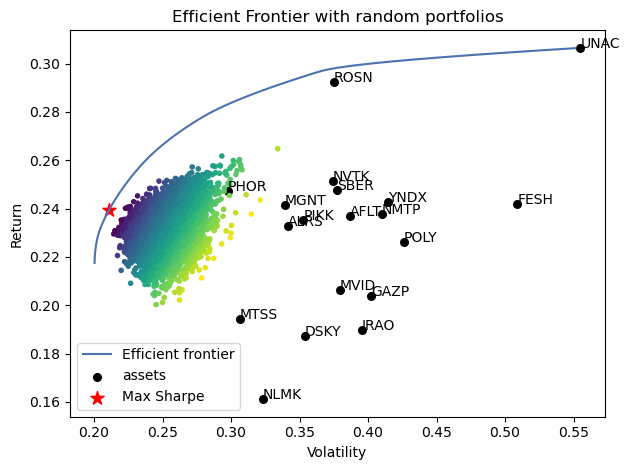

In [20]:
plot_efficient_frontier(
    EfficientFrontier(exp_returns, assets_cov, weight_bounds=(0,1))
)

In [21]:
cleaned_opt_weights

OrderedDict([('GAZP', 0.0),
             ('YNDX', 0.0),
             ('UNAC', 0.0596),
             ('NMTP', 0.03028),
             ('FESH', 0.01669),
             ('PIKK', 0.10102),
             ('AFLT', 0.05943),
             ('DSKY', 0.03926),
             ('MVID', 0.02995),
             ('MGNT', 0.04313),
             ('POLY', 0.03791),
             ('ALRS', 0.00954),
             ('NLMK', 0.0),
             ('PHOR', 0.41071),
             ('MTSS', 0.12033),
             ('SBER', 0.0),
             ('IRAO', 0.0),
             ('NVTK', 0.0),
             ('ROSN', 0.04216)])

# Генерация траекторий цен активов

In [26]:
def simulate_stock_prices(
        stockData:pd.DataFrame, 
        mc_sims:int, 
        time_periods:int, 
        dt=1.0
        ) -> np.ndarray:
    """
    Arguments
    ----------
    stocksData : pd.DataFrame
        DataFrame with stock Close prices,
    mc_sims : int
        number of trajectories to simulate
    time_periods : int
        number of periods to predict
    dt : flaot
        equals to 1 by default as mean return and covarince matrix is calculated inside the function

    Returns
    -------
    price_predict : np.nparray(mc_sims, stock_number, time_periods)
        a np.ndarray with predicted prices, the 0-th is the last Close price
    """
    global stocks_number, stock_tickers
    returns = stockData.pct_change()
    meanReturns = returns.mean().values
    covMatrix = returns.cov().values
    corrMatrix = returns.corr().values

    stocks_number = covMatrix.shape[0]
    stock_tickers = list(stockData.columns.values)

    prices_predicted = np.zeros(shape=(mc_sims, stocks_number, time_periods+1))
    #generating various trajectories
    for m in tqdm(range(0, mc_sims)):
        Z = np.random.normal(size=(time_periods, stocks_number))
        L = np.linalg.cholesky(corrMatrix)
        Z_corr = np.dot(L, Z.T).T
        for stock_number in range(stocks_number):
            #zero index stands for now(it isn't predicted)
            prices_predicted[m, stock_number, 0] = stockData.iloc[-1, stock_number]
            for time in range(1, time_periods+1):
                prices_predicted[m, stock_number, time] = prices_predicted[m, stock_number, time - 1] * np.exp(
                (meanReturns[stock_number] - 0.5 * covMatrix[stock_number, stock_number]) * dt + np.sqrt(covMatrix[stock_number, stock_number]) * Z_corr[time - 1, stock_number] * np.sqrt(dt)
                )
    return prices_predicted

In [27]:
df_assets

GAZP    YNDX    UNAC    NMTP    FESH   PIKK    AFLT   DSKY  \
TRADEDATE                                                                  
2018-10-31  155.47  1916.5  0.8090   6.135   4.990  352.3   97.25  89.50   
2018-11-01  153.50  1999.0  0.8230   6.150   5.055  353.7   96.88  90.38   
2018-11-02  153.71  1995.0  0.8270   6.185   5.110  353.2  101.78  90.76   
2018-11-06  156.00  2002.0  0.8480   6.315   5.125  353.4  102.40  90.50   
2018-11-07  157.85  1995.0  0.8550   6.525   5.090  351.2  100.60  90.30   
...            ...     ...     ...     ...     ...    ...     ...    ...   
2023-10-25  169.62  2737.0  1.8785  12.895  95.680  751.0   40.87  71.42   
2023-10-26  168.45  2682.4  1.8080  12.640  93.710  742.4   39.98  71.42   
2023-10-27  167.26  2666.6  1.8085  12.620  93.140  730.9   40.26  71.42   
2023-10-30  167.16  2603.6  1.7900  12.630  93.260  722.0   39.89  71.42   
2023-10-31  167.88  2612.0  1.7530  12.410  90.480  707.5   39.35  71.40   

             MVID    MGNT   POLY    ALRS    NLMK    PHOR    MTSS    SBER  \
TRADEDATE                                                                  
2018-10-31  398.5  3590.0  608.0   99.90  160.42  2470.0  257.60  189.80   
2018-11-01  401.7  3640.0  624.0  100.70  159.06  2480.0  258.25  188.67   
2018-11-02  407.0  3660.0  619.4  101.60  157.94  2509.0  262.20  192.60   
2018-11-06  404.9  3695.0  615.0  103.04  157.92  2527.0  264.00  197.80   
2018-11-07  407.2  3720.0  625.0  103.00  157.60  2532.0  270.95  201.90   
...           ...     ...    ...     ...     ...     ...     ...     ...   
2023-10-25  199.9  6046.5  549.5   71.54  191.68  6877.0  283.85  273.73   
2023-10-26  195.9  5913.0  543.0   70.79  192.10  6810.0  279.55  269.90   
2023-10-27  192.8  6015.0  547.3   70.74  191.50  6790.0  282.15  269.70   
2023-10-30  193.4  5948.0  547.7   70.03  192.14  6734.0  277.70  269.89   
2023-10-31  190.2  5818.0  538.3   69.98  189.76  6641.0  271.75  268.35   

              IRAO    NVTK    ROSN  
TRADEDATE                           
2018-10-31  3.9820  1049.8  460.45  
2018-11-01  3.9985  1082.1  460.00  
2018-11-02  3.9445  1080.4  459.60  
2018-11-06  4.0000  1081.6  482.45  
2018-11-07  4.0245  1103.8  484.10  
...            ...     ...     ...  
2023-10-25  4.5000  1695.0  590.50  
2023-10-26  4.3735  1682.0  583.00  
2023-10-27  4.3785  1678.4  594.60  
2023-10-30  4.3680  1681.0  587.20  
2023-10-31  4.2805  1661.0  574.55  

[1252 rows x 19 columns]

In [30]:
prices_predicted = simulate_stock_prices(
    stockData=df_assets,
    mc_sims=5_000,
    time_periods=12*20,
    dt=1.0
)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:38<00:00, 50.70it/s]


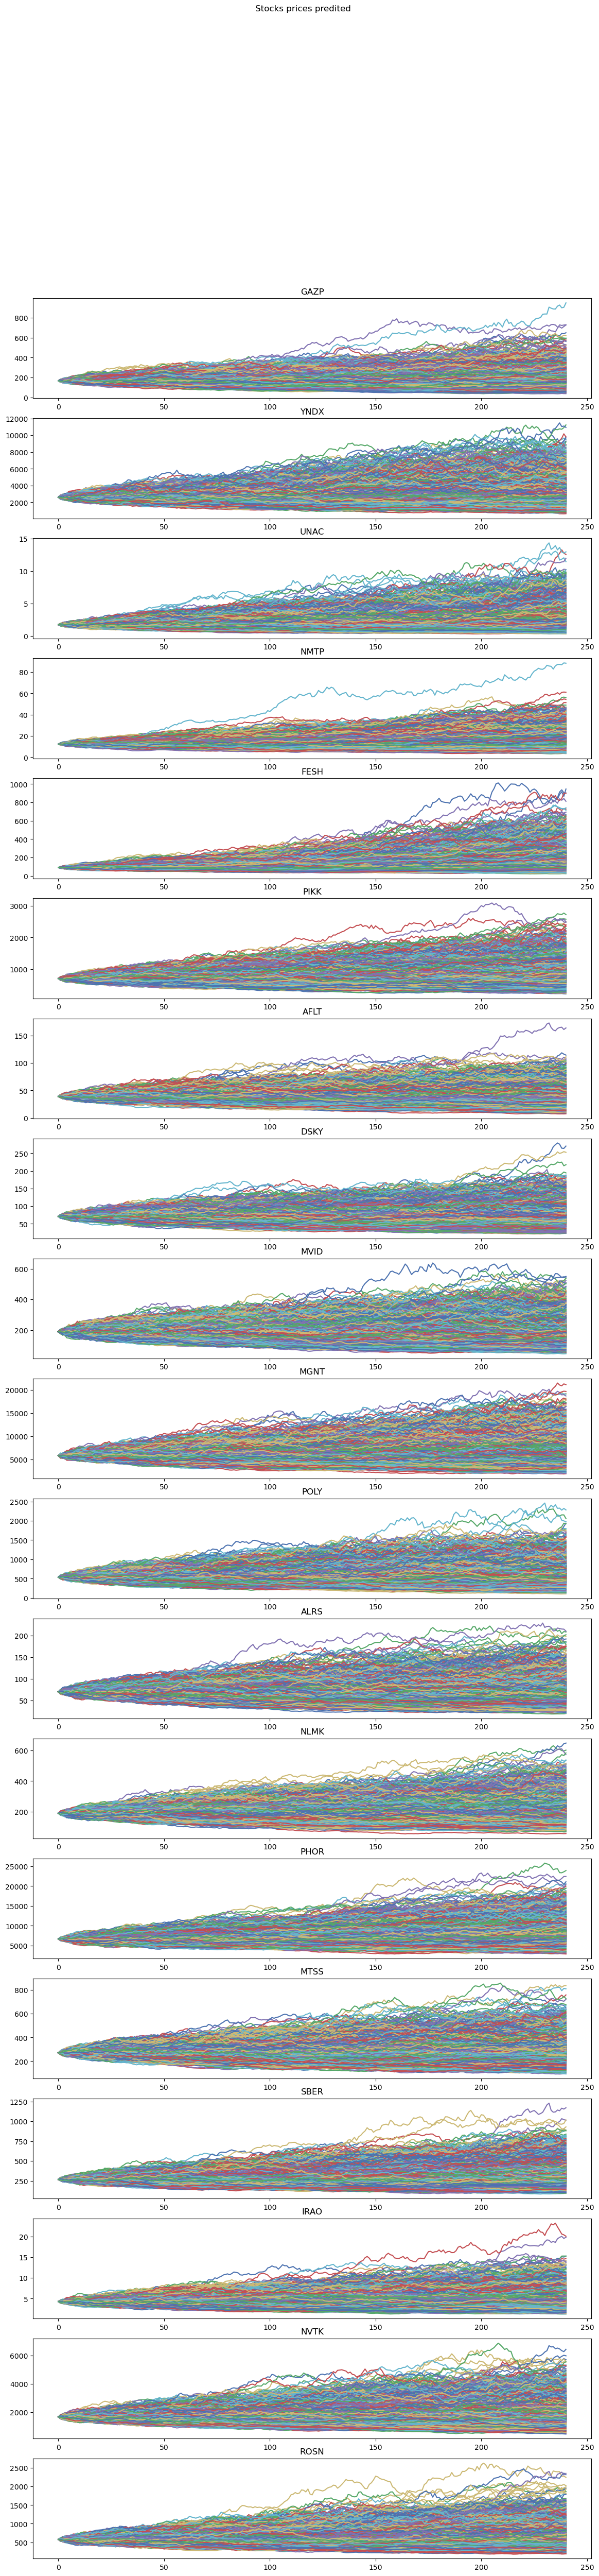

In [35]:
fig, axs = plt.subplots(stocks_number)
fig.set_size_inches(14, stocks_number * 3)
fig.suptitle('Stocks prices predited')
for stock_number in range(stocks_number):
    axs[stock_number].set_title(stock_tickers[stock_number])
    axs[stock_number].plot(prices_predicted[:, stock_number, :].T)

# Вычисление распределения доходностей нашего портфеля

In [18]:
def static_rebalance(current_assets: list,
                     current_prices: list,
                     proportions: list,
                     cash_flow: float) -> list:
    
    """This function takes lists of current assets (number of each), 
    their current prices, needed proportions of values (estimated through theory),
    and cash flow (deposit or withdraw).
    It rerurns the list of rebalanced numbers of each asset"""
    
    # len of all lists should be the same
    if (len(current_assets) != len(current_prices)) or (len(current_assets) != len(proportions)):
        raise ValueError('All lists should have same size')
    
    # calculating total value of our current shares
    total_value = 0
    for i in range(len(current_assets)):
        total_value += current_assets[i] * current_prices[i]
    
    # add deposit/withdraw
    total_value += cash_flow
    if total_value < 0:
        raise ValueError('Too big withdraw')
    
    # calculating new numbers
    rebalanced_assets = []
    for i in range(len(proportions)):
        rebalanced_assets.append(total_value * proportions[i] / current_prices[i])
        
    return rebalanced_assets

def total_value_func(current_assets: list, current_prices: list) -> float:
    total_value = 0
    for i in range(len(current_assets)):
        total_value += current_assets[i] * current_prices[i]
    return total_value

In [41]:
df_assets

GAZP    YNDX    UNAC    NMTP    FESH   PIKK    AFLT   DSKY  \
TRADEDATE                                                                  
2018-10-31  155.47  1916.5  0.8090   6.135   4.990  352.3   97.25  89.50   
2018-11-01  153.50  1999.0  0.8230   6.150   5.055  353.7   96.88  90.38   
2018-11-02  153.71  1995.0  0.8270   6.185   5.110  353.2  101.78  90.76   
2018-11-06  156.00  2002.0  0.8480   6.315   5.125  353.4  102.40  90.50   
2018-11-07  157.85  1995.0  0.8550   6.525   5.090  351.2  100.60  90.30   
...            ...     ...     ...     ...     ...    ...     ...    ...   
2023-10-25  169.62  2737.0  1.8785  12.895  95.680  751.0   40.87  71.42   
2023-10-26  168.45  2682.4  1.8080  12.640  93.710  742.4   39.98  71.42   
2023-10-27  167.26  2666.6  1.8085  12.620  93.140  730.9   40.26  71.42   
2023-10-30  167.16  2603.6  1.7900  12.630  93.260  722.0   39.89  71.42   
2023-10-31  167.88  2612.0  1.7530  12.410  90.480  707.5   39.35  71.40   

             MVID    MGNT   POLY    ALRS    NLMK    PHOR    MTSS    SBER  \
TRADEDATE                                                                  
2018-10-31  398.5  3590.0  608.0   99.90  160.42  2470.0  257.60  189.80   
2018-11-01  401.7  3640.0  624.0  100.70  159.06  2480.0  258.25  188.67   
2018-11-02  407.0  3660.0  619.4  101.60  157.94  2509.0  262.20  192.60   
2018-11-06  404.9  3695.0  615.0  103.04  157.92  2527.0  264.00  197.80   
2018-11-07  407.2  3720.0  625.0  103.00  157.60  2532.0  270.95  201.90   
...           ...     ...    ...     ...     ...     ...     ...     ...   
2023-10-25  199.9  6046.5  549.5   71.54  191.68  6877.0  283.85  273.73   
2023-10-26  195.9  5913.0  543.0   70.79  192.10  6810.0  279.55  269.90   
2023-10-27  192.8  6015.0  547.3   70.74  191.50  6790.0  282.15  269.70   
2023-10-30  193.4  5948.0  547.7   70.03  192.14  6734.0  277.70  269.89   
2023-10-31  190.2  5818.0  538.3   69.98  189.76  6641.0  271.75  268.35   

              IRAO    NVTK    ROSN  
TRADEDATE                           
2018-10-31  3.9820  1049.8  460.45  
2018-11-01  3.9985  1082.1  460.00  
2018-11-02  3.9445  1080.4  459.60  
2018-11-06  4.0000  1081.6  482.45  
2018-11-07  4.0245  1103.8  484.10  
...            ...     ...     ...  
2023-10-25  4.5000  1695.0  590.50  
2023-10-26  4.3735  1682.0  583.00  
2023-10-27  4.3785  1678.4  594.60  
2023-10-30  4.3680  1681.0  587.20  
2023-10-31  4.2805  1661.0  574.55  

[1252 rows x 19 columns]

In [ ]:
start_assets = {}
needed_proportions = []
for one_ticker in stock_tickers:
    start_assets[one_ticker] = 0
    needed_proportions.append(cleaned_opt_weights[one_ticker])
    
# потом будет импортировать эти числа из икселя
cash_list = [50_000] * len(prices_predicted[0][0])

In [12]:
riskfree_price[-1]

9.50942001063615

In [83]:


if len(prices_predicted[0][0]) != len(cash_list):
    raise ValueError("Cash flow and Asset price vectors should have same size") 

monthly_values = []
final_values = []
    
for one_traj in tqdm(range(len(prices_predicted))):
    one_traj_monthly = []
    assets_amounts = list(start_assets.values())
    assets_tickers = list(start_assets.keys())
    for one_date in range(len(cash_list)):

        #get cashflow for this date
        cashflow = cash_list[one_date]

        #get current assets prices
        c_prices = []
        for one_asset in range(len(assets_tickers)):
            
            one_price = prices_predicted[one_traj][one_asset][one_date]
            c_prices.append(one_price)

        assets_amounts = static_rebalance(assets_amounts, c_prices, needed_proportions, cashflow)
        total_value = total_value_func(assets_amounts, c_prices)
        
        one_traj_monthly.append(total_value)
        
    monthly_values.append(one_traj_monthly)
    final_values.append(total_value)
        

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:30<00:00, 163.97it/s]


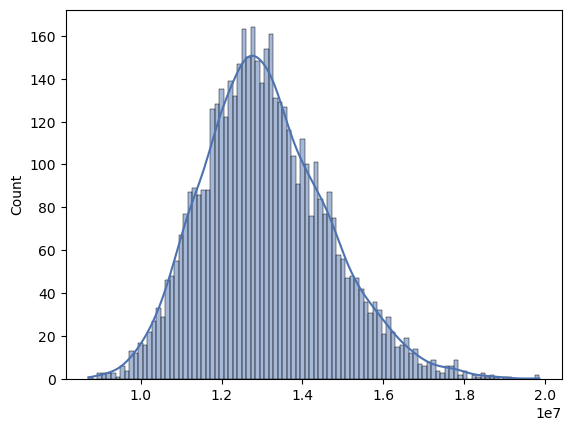

In [91]:
sns.histplot(final_values, kde=True, bins = 100);

In [24]:
riskfree_price = [1]
# one_m = ((1 + 11.92 / 100)**20 - 1) / 240
one_m = ((1 + 4 / 100)**20 - 1) / 240
for i in range(240):
    riskfree_price.append(riskfree_price[-1] + one_m)

In [26]:
# когда инвестируем все в риск-фри
needed_proportions = [1]
assets_amounts = [0]
one_traj_monthly = []
for one_date in range(len(riskfree_price)):

    #get cashflow for this date
    cashflow = cash_list[one_date]

    #get current assets prices
    c_prices = [riskfree_price[one_date]]

    assets_amounts = static_rebalance(assets_amounts, c_prices, needed_proportions, cashflow)
    total_value = total_value_func(assets_amounts, c_prices)

    one_traj_monthly.append(total_value)
    

In [27]:
one_traj_monthly

[50000.0,
 100248.15065479864,
 150743.22647158324,
 201484.01400225871,
 252469.31166674424,
 303697.92957970954,
 355168.68938066746,
 406880.42406734236,
 458831.9778322349,
 511022.20590230776,
 563449.974381718,
 616114.1600975234,
 669013.6504482938,
 722147.3432555585,
 775514.1466180244,
 829112.9787684995,
 882942.7679334607,
 937002.452195204,
 991290.9793565185,
 1045807.3068078266,
 1100550.4013967342,
 1155519.239299937,
 1210712.8058974294,
 1266130.095648966,
 1321770.1119727218,
 1377631.8671261081,
 1433714.3820886905,
 1490016.6864471668,
 1546537.8182823588,
 1603276.8240581735,
 1660232.75851249,
 1717404.6845499347,
 1774791.6731364983,
 1832392.8031959601,
 1890207.1615080785,
 1948233.8426085105,
 2006471.9486904244,
 2064920.589507769,
 2123578.882280167,
 2182445.951599394,
 2241520.9293374154,
 2300802.954555945,
 2360291.1734174974,
 2419984.7390978998,
 2479882.8117002347,
 2539984.5581701873,
 2600289.1522127646,
 2660795.774210361,
 2721503.611142142,
 278